In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
#import xgboost as xgb
#import catboost as cb
%matplotlib inline
pd.set_option('display.max_columns', None)


In [37]:
df_train = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/exam_score.csv')
df_test = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/test_s1/submission_s1.csv')
df_test.rename(columns={'pred':'score'},inplace = True)
course_class = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course.csv')
student = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/student.csv')
all_know = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/all_knowledge.csv')
df_all = df_train.append(df_test)
df_all = df_all.merge(course_class, on='course', how='left')
df_all = df_all.merge(student, on='student_id', how='left')


In [38]:
tmp1 = df_train.groupby(by=['student_id','course'], as_index=False)['score'].agg({'mean_score':np.mean, 'median_score':np.median, 'std_score':np.std,'max_score':np.max,'min_score':np.min})
tmp2 = df_train.groupby(by=['student_id'], as_index=False)['score'].agg({'s_mean_score':np.mean, 's_median_score':np.median, 's_std_score':np.std,'s_max_score':np.max,'min_score':np.min})


In [39]:
df_all=df_all.merge(tmp1, on=['student_id','course'], how='left')
df_all=df_all.merge(tmp2, on=['student_id'], how='left')


In [40]:
course1_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course1_exams.csv')
course2_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course2_exams.csv')
course3_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course3_exams.csv')
course4_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course4_exams.csv')
course5_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course5_exams.csv')
course6_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course6_exams.csv')
course7_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course7_exams.csv')
course8_exam = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/train_s1/course8_exams.csv')
#col_c1 = [i for i in course1_exam.columns if i not in ['course','exam_id']]
tmp4=1
for i in [course1_exam,course2_exam,course3_exam,course4_exam,course5_exam,course6_exam,course7_exam,course8_exam]:
    name = i
    col_c1 = [i for i in name.columns if i not in ['course','exam_id']]
    name['course'] ='course'+str(tmp4)
    tmp2 =np.array(all_know.loc[all_know['course'] == ('course'+str(tmp4)),:]['complexity'])
    tmp = name[col_c1]
    tmp3 =np.dot(tmp.values,tmp2)
    name['hard'] = tmp3
    name['hard_inverse'] = name['hard'].apply(lambda x:1/(x+1e-10))
    tmp4 = tmp4+1

course_exam = course1_exam.append(course2_exam)
course_exam = course_exam.append(course3_exam)
course_exam = course_exam.append(course4_exam)
course_exam = course_exam.append(course5_exam)
course_exam = course_exam.append(course6_exam)
course_exam = course_exam.append(course7_exam)
course_exam = course_exam.append(course8_exam)
course_exam.fillna(0,inplace = True)


/home/wjunneng/Python/anaconda3/envs/lightgbm/lib/python3.6/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [41]:
sub_course_exam = course_exam[['course','exam_id','hard','hard_inverse']]


In [42]:
df_all.shape


(73500, 16)

In [43]:
df_all=df_all.merge(sub_course_exam, on=['exam_id','course'], how='left')


In [44]:
df_all.shape


(73500, 18)

In [45]:
for i in ['course','course_class','exam_id','student_id']:
    lbl = LabelEncoder()
    #all_data[i+"_count"] = all_data.groupby([i])[i].transform('count')
    #all_data[i+"_rank"] = all_data[i+"_count"].rank(method='min')
    df_all[i] = lbl.fit_transform(df_all[i].astype(str))


In [46]:
df_train = df_all[:65500]
df_test = df_all[65500:].reset_index(drop=True)
col = [i for i in df_all.columns if i not in ['score']]
X_train = df_train[col]
y = df_train['score']


In [47]:
X_train.head()


,student_id,course,exam_id,course_class,gender,mean_score,median_score,std_score,max_score,min_score_x,s_mean_score,s_median_score,s_std_score,s_max_score,min_score_y,hard,hard_inverse
0,80,0,118,0,0,82.611111,82.5,8.395649,98,67,76.290076,77,9.713186,98,0,175,0.005714
1,48,0,118,0,0,78.222222,77.5,4.037407,88,71,86.068702,86,7.208105,100,71,175,0.005714
2,217,0,118,0,0,80.666667,80.0,7.483315,96,66,80.511450,81,6.476426,96,66,175,0.005714
3,329,0,118,0,1,82.555556,82.0,5.124591,92,76,88.847328,90,7.665581,100,68,175,0.005714
4,237,0,118,0,0,80.055556,80.0,4.398826,89,71,82.129771,83,12.204915,99,0,175,0.005714


In [48]:
test_y = np.zeros(len(df_test))
random_seed = 2018
cv_model = []
cv_score = []
skf = StratifiedKFold(n_splits=5, random_state=random_seed, shuffle=True)
for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
    #print(index)
    train_x, val_x, train_y, val_y = X_train.iloc[train_index], X_train.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'n_estimators': 10000,
        #'metric': 'mae',
        'learning_rate': 0.01,
        'min_child_samples': 46,
        'min_child_weight': 0.01,
        'subsample_freq': 1,
        'num_leaves': 40,
        'max_depth': 7,
        'subsample': 0.42,
        'colsample_bytree': 0.48,
        'reg_alpha': 0.15,
        'reg_lambda': 5,
        'verbose': -1,
        'seed': 4590
    }
    lgb = LGBMRegressor(**lgb_params)


    lgb.fit(
        train_x,
        train_y,
        eval_set=[(train_x, train_y), (val_x, val_y)],
        eval_names=['train', 'val'],
        eval_metric='rmse',
        #eval_metric = evaluate_macroF1_lgb, 
        early_stopping_rounds=20,
        verbose=10,
    )
    cv_model.append(lgb)
    lgb.n_estimators = lgb.best_iteration_
    val_y_pred = lgb.predict(val_x)
    cv_score.append( np.sqrt(mean_squared_error(val_y,val_y_pred)))
    test_y += lgb.predict(df_test[col])/5
print("CV score: ",np.mean(cv_score))


Training until validation scores don't improve for 20 rounds.
[10]	train's rmse: 9.44391	train's l2: 89.1875	val's rmse: 9.46102	val's l2: 89.5108
[20]	train's rmse: 8.94058	train's l2: 79.934	val's rmse: 8.95885	val's l2: 80.2611
[30]	train's rmse: 8.49467	train's l2: 72.1594	val's rmse: 8.51467	val's l2: 72.4996
[40]	train's rmse: 8.09421	train's l2: 65.5163	val's rmse: 8.11548	val's l2: 65.8611
[50]	train's rmse: 7.75774	train's l2: 60.1825	val's rmse: 7.7808	val's l2: 60.5409
[60]	train's rmse: 7.44475	train's l2: 55.4243	val's rmse: 7.46978	val's l2: 55.7976
[70]	train's rmse: 7.18888	train's l2: 51.68	val's rmse: 7.21644	val's l2: 52.077
[80]	train's rmse: 6.9601	train's l2: 48.443	val's rmse: 6.98994	val's l2: 48.8593
[90]	train's rmse: 6.75894	train's l2: 45.6833	val's rmse: 6.79148	val's l2: 46.1242
[100]	train's rmse: 6.5952	train's l2: 43.4966	val's rmse: 6.63043	val's l2: 43.9626
[110]	train's rmse: 6.45178	train's l2: 41.6255	val's rmse: 6.49054	val's l2: 42.1271
[120]	tra

/home/wjunneng/Python/anaconda3/envs/lightgbm/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [49]:
test_y


array([81.61697357, 77.79347135, 79.81865341, ..., 75.74669072,
       71.2816731 , 70.32504392])

In [50]:
sub_test = pd.read_csv('/home/wjunneng/Python/ForecastScore/data/test_s1/submission_s1.csv')


In [51]:
sub_test['pred'] = test_y


In [52]:
sub_test


,student_id,course,exam_id,pred
0,230748,course1,m31I6cTD,81.616974
1,186851,course1,m31I6cTD,77.793471
2,478370,course1,m31I6cTD,79.818653
3,692328,course1,m31I6cTD,82.282675
4,509128,course1,m31I6cTD,79.493475
5,604234,course1,m31I6cTD,96.732014
6,992922,course1,m31I6cTD,78.152273
7,488841,course1,m31I6cTD,91.100404
8,831322,course1,m31I6cTD,80.736409
9,940245,course1,m31I6cTD,77.279305


In [53]:
sub_test.to_csv('/home/wjunneng/Python/ForecastScore/data/test_s1/submission_s1_sample_baseline_1.csv',index=None)


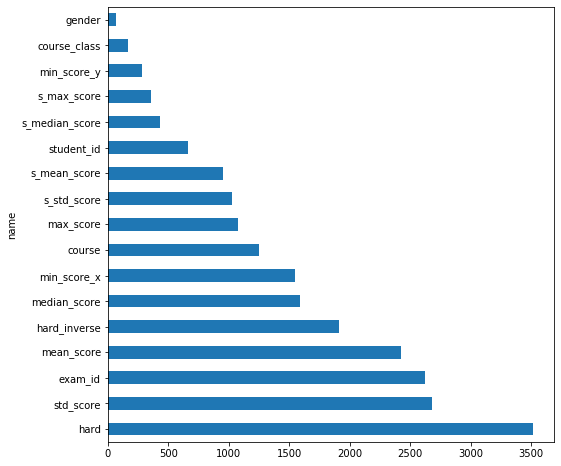

In [54]:
fi = []
for i in cv_model:
    tmp = {
        'name' : col,
        'score' : i.feature_importances_
    }
    fi.append(pd.DataFrame(tmp))
    
fi = pd.concat(fi)
fig = plt.figure(figsize=(8,8))
fi.groupby(['name'])['score'].agg('mean').sort_values(ascending=False).head(40).plot.barh()